In [1]:
%%time
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import timeit


#import sys
#print(sys.path)

%matplotlib inline

import h5py
from pathlib import Path

from FKMC.quantum_montecarlo import quantum_cython_mcmc, update_bins
from FKMC.stats import spin_spin_correlation


config = dict(  N_steps = 300,
                N_burn_in = 50,
                N_system = 64,
                mu = 0,
                beta = 0.6,
                V=-1,
                alpha=1.25,
                U = 3,
                N_energy_bins= 500,
                output_state = True,
                output_correlator=True,
                output_history=True,
                quantum = True,
                job_id = 1020242,
                bins = 20,
               )

results = quantum_cython_mcmc(**config)
print('keys in results: ', results.keys())

#access dictionary keys as fields
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
        
r = objectview(results)

states = results['states']
correlation = spin_spin_correlation(r.ts)

steps = np.arange(config['N_steps'])
sites = np.arange(config['N_system'])
print(f'''
Number of occupied sites: {r.numbers.mean()}
Magnetisations of staggered spin variables: {r.magnetisations.mean()}
state.shape: {r.states.shape}
''')

keys in results:  dict_keys(['flag_6', 'classical_energies_moments', 'numbers_moments', 'magnetisations_moments', 'quantum_energies_moments', 'classical_energies_moments_err', 'numbers_moments_err', 'magnetisations_moments_err', 'quantum_energies_moments_err', 'correlator', 'q_energy_histogram', 'IPR_histogram', 'q_energy_histogram_bins', 'q_energy_bounds', 'classical_energies', 'numbers', 'magnetisations', 'quantum_energies', 'states', 'ts', 'eigenvalue_hist', 'eigenvector_hist'])

Number of occupied sites: 0.5852083333333333
Magnetisations of staggered spin variables: -0.05645833333333333
state.shape: (300, 64)

CPU times: user 33.6 s, sys: 312 ms, total: 33.9 s
Wall time: 8.68 s


In [2]:
import cython
%load_ext Cython

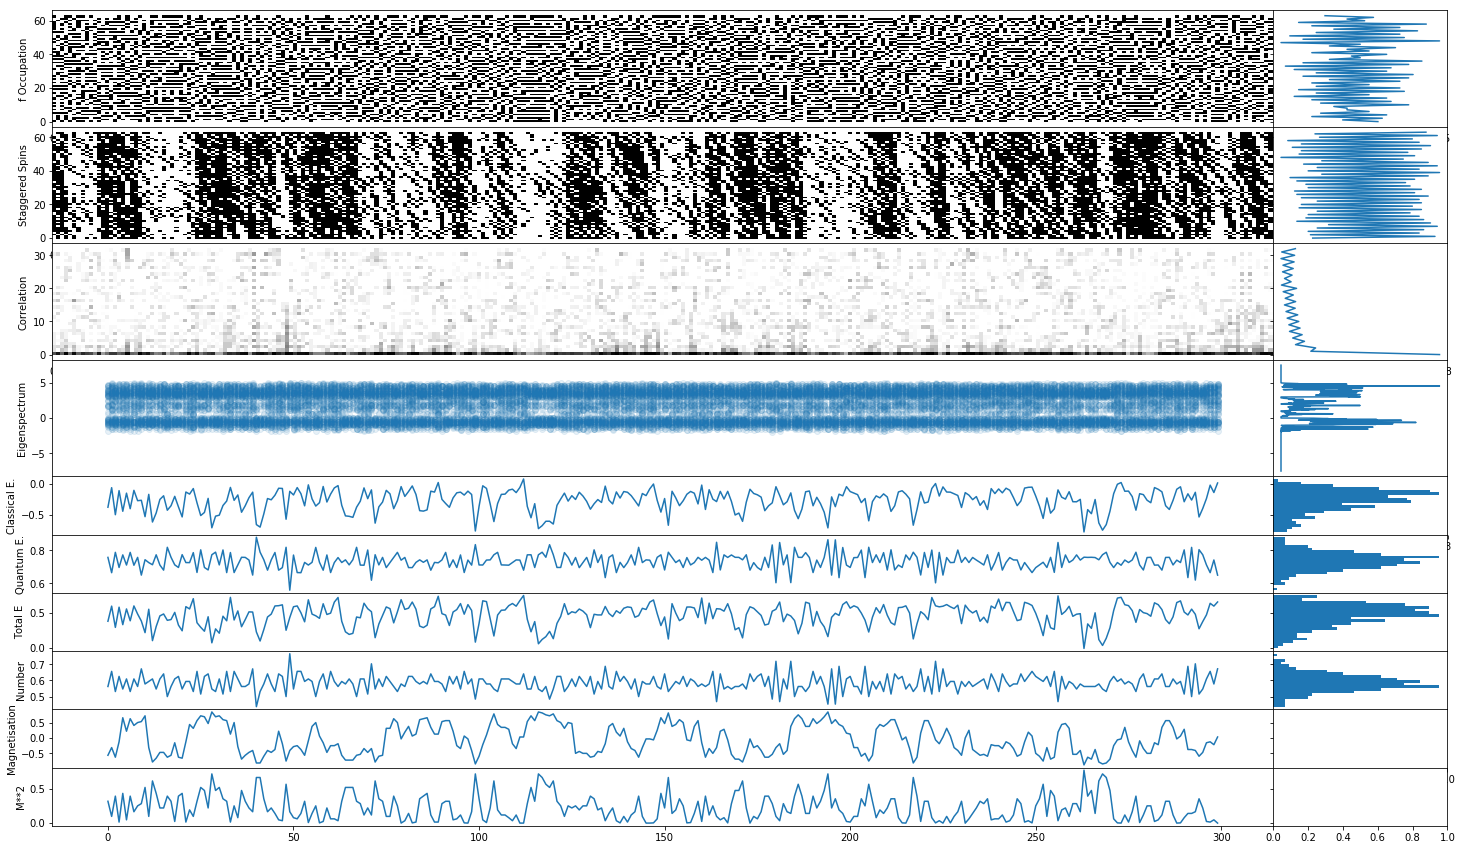

In [3]:
#things to fix

##todo
### sync static_cx1_home with cx1_home
## compile on cx1
## start another phase diagram
## do a IPR vs systems plot

##look at output of phase_diagram_6 and IPR_scaling
## implement incremental saving
## implement looping over some work internally!!!

f, axes = plt.subplots(10,2, figsize = (25,15), sharey = 'row', gridspec_kw = dict(height_ratios=[2,2,2,2,1,1,1,1,1,1], width_ratios=[7, 1],wspace=0, hspace=0))

axs, axs1 = axes.T
observables = [_, _, _, _, r.classical_energies, r.quantum_energies, r.quantum_energies + r.classical_energies, r.numbers, r.magnetisations, r.magnetisations**2]
observable_ylabels = ['f Occupation', 'Staggered Spins', 'Correlation', 'Eigenspectrum','Classical E.', 'Quantum E.', 'Total E', 'Number', 'Magnetisation', 'M**2']

axs[0].pcolor(steps, sites, r.states.T, cmap = 'gray', vmin = 0, vmax = 1)
axs[1].pcolor(steps, sites, r.ts.T, cmap = 'gray', vmin = -1, vmax = 1)
axs[2].pcolor(steps, sites[:correlation.shape[-1]], 1-correlation.T, cmap = 'gray', vmin = 0, vmax = 1)

x = np.reshape(steps[:, np.newaxis] * np.ones_like(r.eigenvalue_hist), [-1,])
y = np.reshape(r.eigenvalue_hist, [-1])
axs[3].scatter(x, y, alpha = 0.1,)

#count the number of eigenvals in each square in each energy bin
indx = np.digitize(r.eigenvalue_hist, r.q_energy_histogram_bins)
#bin_averages= np.array([IPRs[indx == i].mean() for i in np.arange(len(bins))])

for ax,observable in list(zip(axs,observables))[4:]: ax.plot(steps, observable)

axs1[0].plot(r.states.mean(axis=0), sites)
axs1[1].plot(r.ts.mean(axis=0), sites)
axs1[2].plot(correlation.mean(axis=0), sites[:correlation.shape[-1]])


hist_kwargs = dict(orientation='horizontal', bins = 20, density = True)
axs1[3].plot(r.q_energy_histogram / np.sum(r.q_energy_histogram), r.q_energy_histogram_bins[:-1])

for ax,observable in list(zip(axs1,observables))[4:8]: ax.hist(observable, **hist_kwargs)

for ylabel, ax in zip(observable_ylabels, axs): ax.set(ylabel=ylabel)
axs[5].set(xlabel = 'MC Step (One trial per site per step)');

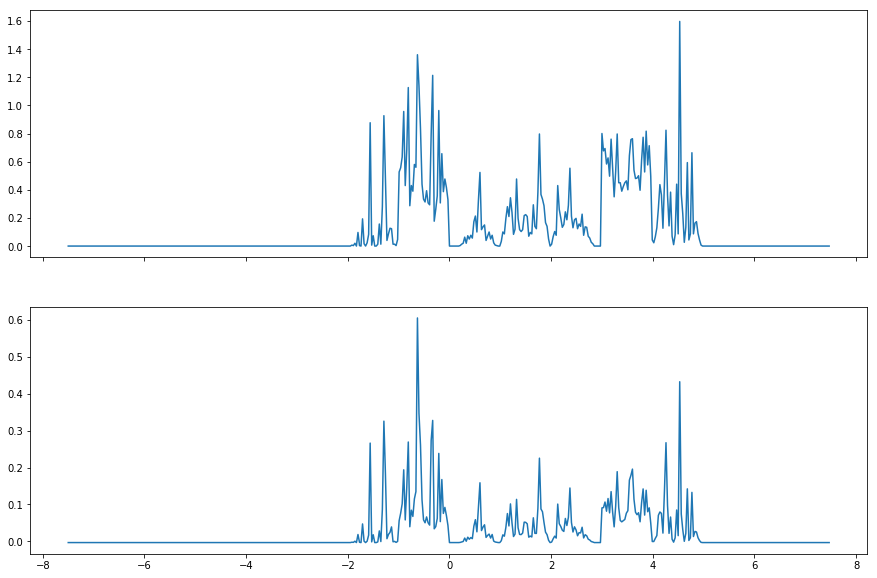

In [4]:
f, axes = plt.subplots(2,1, figsize = (15,10), sharex = 'col')

axes[0].plot(r.q_energy_histogram_bins[:-1], r.q_energy_histogram)
axes[1].plot(r.q_energy_histogram_bins[:-1], r.IPR_histogram)